In [8]:
!pip install yfinance ta scikit-learn matplotlib seaborn xgboost


Choose a stock symbol (e.g., AAPL, GOOGL, MSFT, AMZN, TSLA)
Enter stock symbol (default=AAPL): AAPL


[*********************100%***********************]  1 of 1 completed



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.18      0.27        78
           1       0.47      0.81      0.59        69

    accuracy                           0.48       147
   macro avg       0.49      0.50      0.43       147
weighted avg       0.49      0.48      0.42       147

📌 Confusion Matrix:


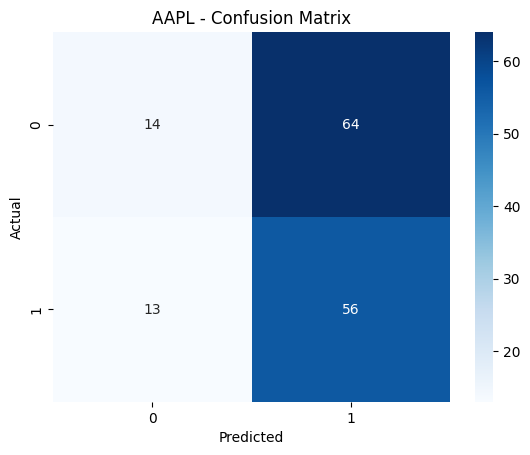

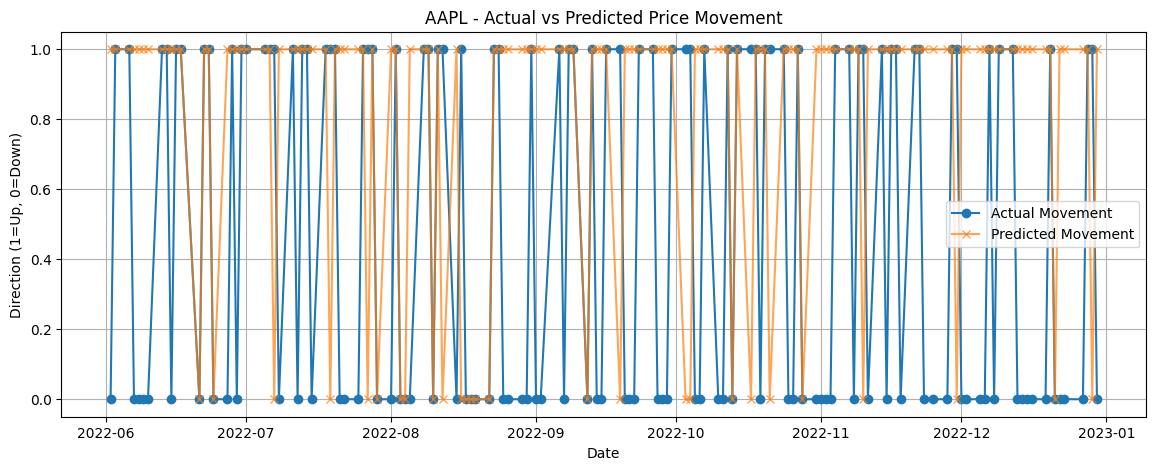

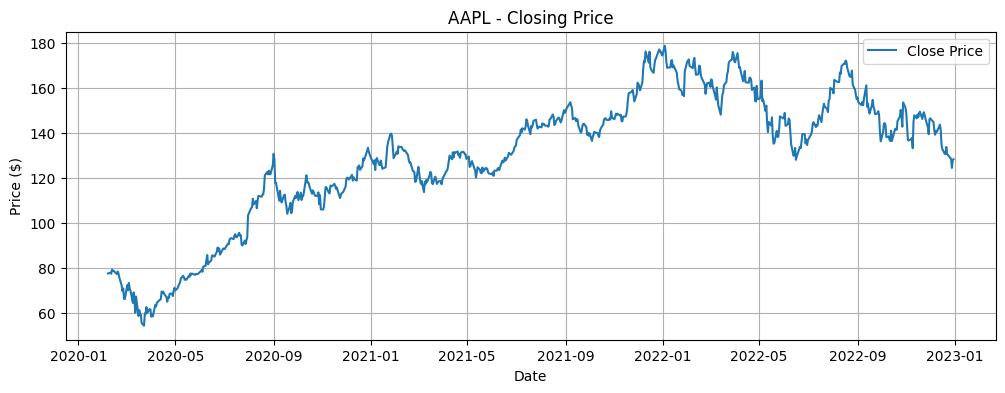

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.trend import MACD
from ta.momentum import RSIIndicator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 0: Stock selection
default_stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
print("Choose a stock symbol (e.g., AAPL, GOOGL, MSFT, AMZN, TSLA)")
stock = input("Enter stock symbol (default=AAPL): ").upper()
if not stock:
    stock = "AAPL"

# Step 1: Load data with validation
try:
    data = yf.download(stock, start="2020-01-01", end="2023-01-01")
    if data.empty:
        raise ValueError("Ticker not found.")
except Exception as e:
    print(f"\n❌ Error loading data for '{stock}': {e}")
    print("👉 Falling back to default ticker AAPL")
    stock = "AAPL"
    data = yf.download(stock, start="2020-01-01", end="2023-01-01")

# Proceed if data is valid
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.dropna(inplace=True)

# Step 2: Feature Engineering
close_series = data[['Close']].squeeze()
data['Return'] = close_series.pct_change()
data['RSI'] = RSIIndicator(close=close_series, window=14).rsi()
data['MACD'] = MACD(close=close_series).macd()
data['EMA_10'] = close_series.ewm(span=10, adjust=False).mean()
data['EMA_30'] = close_series.ewm(span=30, adjust=False).mean()
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
data.dropna(inplace=True)

# Step 3: Split data
features = ['Return', 'RSI', 'MACD', 'EMA_10', 'EMA_30']
X = data[features]
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Model
model = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Step 5: Evaluation
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📌 Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f"{stock} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 6: Plot prediction
plt.figure(figsize=(14, 5))
plt.plot(data.index[-len(y_test):], y_test.values, label='Actual Movement', marker='o')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted Movement', alpha=0.7, marker='x')
plt.legend()
plt.title(f"{stock} - Actual vs Predicted Price Movement")
plt.xlabel("Date")
plt.ylabel("Direction (1=Up, 0=Down)")
plt.grid(True)
plt.show()

# Step 7: Plot closing price
plt.figure(figsize=(12, 4))
plt.plot(data['Close'], label='Close Price')
plt.title(f"{stock} - Closing Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


Choose a stock symbol (e.g., AAPL, GOOGL, MSFT, AMZN, TSLA)
Enter stock symbol (default=AAPL): GOOGL


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Classification Report (Up/Down):
              precision    recall  f1-score   support

           0       0.45      0.44      0.44       140
           1       0.50      0.51      0.51       156

    accuracy                           0.48       296
   macro avg       0.47      0.47      0.47       296
weighted avg       0.48      0.48      0.48       296



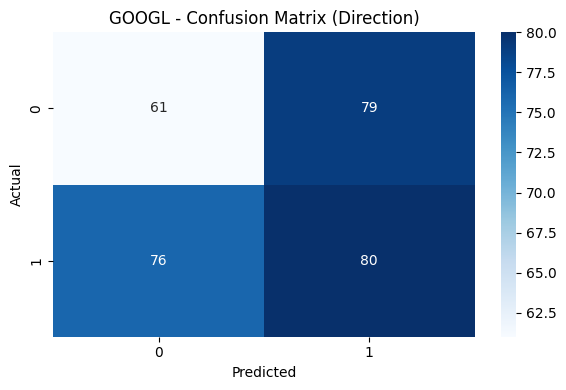


📈 XGBoost Regression - MSE (predict 5 days ahead): 52.9077


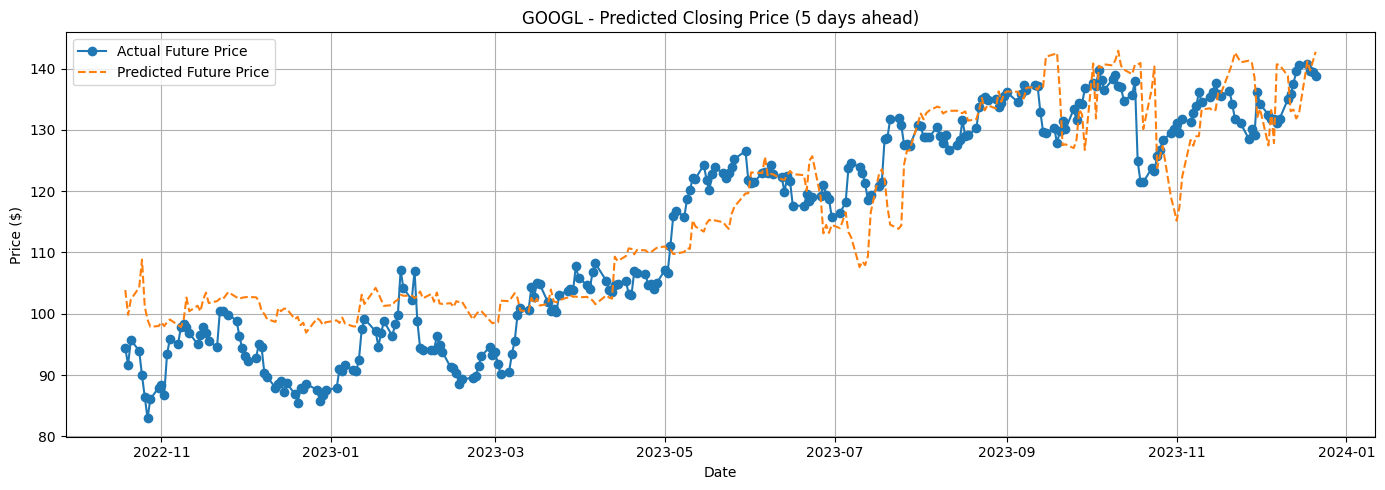

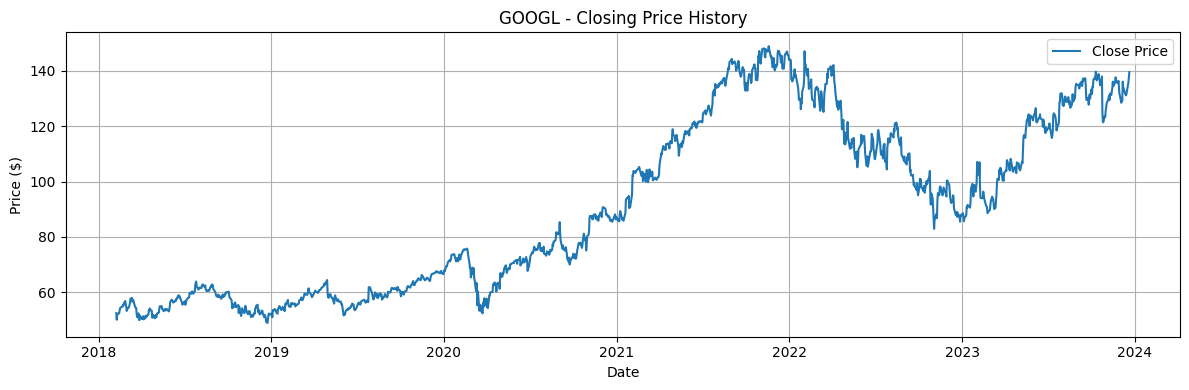

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.trend import MACD
from ta.momentum import RSIIndicator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error,accuracy_score
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ----- Stock selection -----
default_stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
print("Choose a stock symbol (e.g., AAPL, GOOGL, MSFT, AMZN, TSLA)")
stock = input("Enter stock symbol (default=AAPL): ").upper()
if not stock:
    stock = "AAPL"

# ----- Download data -----
try:
    data = yf.download(stock, start="2018-01-01", end="2024-01-01")
    if data.empty:
        raise ValueError("Ticker not found.")
except Exception as e:
    print(f"\n❌ Error loading data for '{stock}': {e}")
    print("👉 Falling back to default ticker AAPL")
    stock = "AAPL"
    data = yf.download(stock, start="2018-01-01", end="2024-01-01")

# Use only necessary columns
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.dropna(inplace=True)

# ----- Feature Engineering -----
data['Return'] = data['Close'].pct_change()

# Ensure 'Close' is a Series, not a DataFrame
close_series = data['Close']
if isinstance(close_series, pd.DataFrame):
    close_series = close_series.squeeze()

data['RSI'] = RSIIndicator(close=close_series, window=14).rsi()
data['MACD'] = MACD(close=close_series).macd()
data['EMA_10'] = close_series.ewm(span=10, adjust=False).mean()
data['EMA_30'] = close_series.ewm(span=30, adjust=False).mean()
data.dropna(inplace=True)


# ----- Labels -----
# Classification: 1 if next day Close > today Close
data['Target_Cls'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

# Regression: predict Close n days in the future
n_days = 5
data['Future_Close'] = data['Close'].shift(-n_days)
data.dropna(inplace=True)

# ----- Feature Set -----
features = ['Return', 'RSI', 'MACD', 'EMA_10', 'EMA_30']

# ----- Classification -----
X_cls = data[features]
y_cls = data['Target_Cls']
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, shuffle=False)

clf = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_cls, y_train_cls)
y_pred_cls = clf.predict(X_test_cls)

# ----- Classification Report -----
print("\n📊 Classification Report (Up/Down):")
print(classification_report(y_test_cls, y_pred_cls))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_cls, y_pred_cls), annot=True, fmt='d', cmap='Blues')
plt.title(f"{stock} - Confusion Matrix (Direction)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ----- Regression -----
X_reg = data[features]
y_reg = data['Future_Close']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, shuffle=False)

reg = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42)
reg.fit(X_train_reg, y_train_reg)
y_pred_reg = reg.predict(X_test_reg)

# ----- Regression Metrics -----
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f"\n📈 XGBoost Regression - MSE (predict {n_days} days ahead): {mse:.4f}")

# ----- Plot actual vs predicted prices -----
plt.figure(figsize=(14, 5))
plt.plot(data.index[-len(y_test_reg):], y_test_reg.values, label='Actual Future Price', marker='o')
plt.plot(data.index[-len(y_test_reg):], y_pred_reg, label='Predicted Future Price', linestyle='--')
plt.title(f"{stock} - Predicted Closing Price ({n_days} days ahead)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Plot closing price trend -----
plt.figure(figsize=(12, 4))
plt.plot(data['Close'], label='Close Price')
plt.title(f"{stock} - Closing Price History")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
